#Artificial Neural Networks and Deep Learning  



##Assignment 3.2 - Convolutional Neural Networks

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we will implement a convolutional neural network from scratch.

We only consider classification tasks here in the session.




In [1]:
# Please first load your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
!nvidia-smi

Mon Mar 11 13:30:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0              27W /  70W |    997MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Convolutional Neural Networks
In this section, we implement CNN from scrath and train it on the MNIST dataset.

We first load the dataset as follows:

In [7]:
import torch
from torch import nn, optim, functional, utils
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

import time, os

import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300


def get_mnist_loader(batch_size=100, num_train_samples = 10000, num_test_samples = 2000):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)


    return train_loader, test_loader

## Build CNN from scratch
Our CNN is of 4 convolutional layers and 2 fully connected layers.
You can try a different amount of layers by simply add more ``self.conv`` layers inside  ``__init__`` and ``forward`` in the following code. Please be careful with the dimensions of the convolutional layers when changing parameters such as convolution channels, kernel_size and stride.

In [8]:
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=16, # convolution channels
                            kernel_size=3, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=1), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(16), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

## Training function
The training process includes loading the model, setting the optimizer, and running on the training set for epochs.
After each training epoch, we evaluate the model on the test set to record the test accuracy.

In [4]:
def train(model, train_epoch, model_save, train_loader, test_loader) :
    # Push model on to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_func = nn.CrossEntropyLoss( )
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters( ),lr=0.001)

    acc_count = []  # record the test accuracy
    for epoch in range(train_epoch):

        model.train()

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)  # torch,Size([128,1,28,28])
            y = y.to(device)   # torch.Size([128])
            # Output of the model
            out = model(x)  # torch.Size([128,10])
            # Compute loss
            loss = loss_func(out, y)

            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()  # update the network parameters

            # save the model checkpoint every 20 iterations
            if i % 20 == 0:
                print('Training Loss:{:.6f} Batch {}/{} '.format(loss.item(), i, len(train_loader)))
                torch.save(model, model_save)

        # evaluate the model after each training epoch
        with torch.no_grad():
            model.eval()

            true_pred = torch.zeros(1).to(device)
            nb_sample = 0

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                _, pred = torch.max(outputs, dim=1)

                true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
                nb_sample += len(inputs)

            acc = true_pred / nb_sample
            acc = acc.item()

            acc_count.append(acc)

            print('Epoch {:d}, Test Accuracy {:.3f} %'.format(epoch, acc * 100))

    return acc_count

## Let's start training!
The network is trained for 20 epochs, batch size of 100.

You can adjust the hyperparameters here if necessary.

In [9]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# Define model
model = CNNnet()

# where to save the model
model_save = './MNIST_CNN/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN'):
    os.mkdir('MNIST_CNN')

In [10]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.315226 Batch 0/100 
Training Loss:0.948422 Batch 20/100 
Training Loss:0.485134 Batch 40/100 
Training Loss:0.340697 Batch 60/100 
Training Loss:0.217932 Batch 80/100 
Epoch 0, Test Accuracy 93.450 %
Training Loss:0.236262 Batch 0/100 
Training Loss:0.125866 Batch 20/100 
Training Loss:0.109215 Batch 40/100 
Training Loss:0.109992 Batch 60/100 
Training Loss:0.199216 Batch 80/100 
Epoch 1, Test Accuracy 95.550 %
Training Loss:0.052785 Batch 0/100 
Training Loss:0.113521 Batch 20/100 
Training Loss:0.089693 Batch 40/100 
Training Loss:0.109155 Batch 60/100 
Training Loss:0.083481 Batch 80/100 
Epoch 2, Test Accuracy 96.300 %
Training Loss:0.019677 Batch 0/100 
Training Loss:0.036255 Batch 20/100 
Training Loss:0.050288 Batch 40/100 
Training Loss:0.026613 Batch 60/100 
Training Loss:0.035146 Batch 80/100 
Epoch 3, Test Accuracy 96.700 %
Training Loss:0.047638 Batch 0/100 
Training Loss:0.013351 Batch 20/100 
Training Loss:0.022498 Batch 40/100 
Training Loss:0.028652 Bat

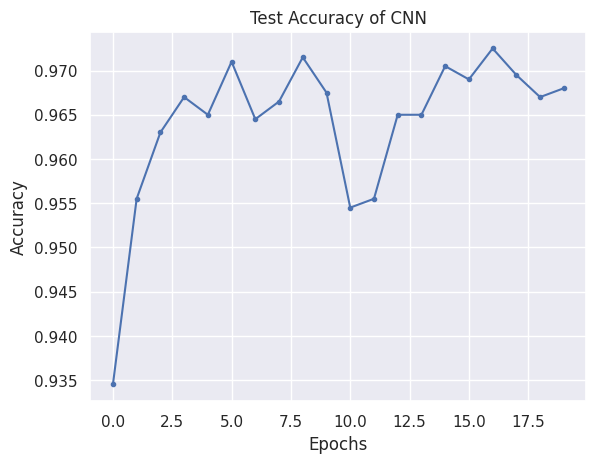

In [11]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()